# Forrest Cover Type Prediction

### w207 Final Project, Spring 2022

Oren Carmeli, Sam Stephens, Stephen Bridwell, Jon Hand.

# Outline

1. Introduction
2. Exploratory Data Analysis (EDA)
3. Baseline Models
4. Generalize Step Optimization 
    + feature engineering
    + hyperparameters
5. Conclusion
6. Appendix

______________________________________________________________________________________________________________________

# 1) Introduction

### Dataset

The dataset is part of a public competition on [kaggle](https://www.kaggle.com/c/forest-cover-type-prediction/data) that includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record in the dataset) is a 30m x 30m patch of land. It includes 10 features in raw form (not scaled) as well as binary flags for qualitative independent variables such as wilderness areas and soil type.


### Business Problem
Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).


### Inference Problem

The inference problem is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). Specifically, our goal is to build a model that maps the cartographic variables (X) to predict a forecast cover type (Y). The data fields are defined below;

#### Data Fields (X)
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

#### Data Fields (Y)
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The integer cover type value corresponds to the following names;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

____________________________________________________________________________________________________________________

# 2) Exploratory Data Analysis (EDA)

### Load Packages

In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

### Create Train, Dev, & Test Objects

In [2]:
np.random.seed(0)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# load data

train = pd.read_csv("../data/train.csv").drop('Id', axis=1)
test = pd.read_csv("../data/test.csv").drop('Id', axis=1)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up modeling datasets

# X = all but last column 
X_train = np.array(train.iloc[:,:-1])
X_test = np.array(test)

# Y = last column only
Y_train = np.array(train.iloc[:,-1].tolist())

# build dev set based on random subset (20% of train data)
shuffle = np.random.permutation(np.arange(X_train.shape[0]))
X_train, Y_train = X_train[shuffle], Y_train[shuffle]

dev_size = round(X_train.shape[0] * 0.2)
dev_data, dev_labels = X_train[:dev_size], Y_train[:dev_size]
train_data, train_labels = X_train[dev_size:], Y_train[dev_size:]
test_data = X_test

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up dataset with cover type names for readible EDA

# append cover type labels
label_categories = ['Spruce/Fir', 
                    'Lodgepole Pine', 
                    'Ponderosa Pine', 
                    'Cottonwood/Willow', 
                    'Aspen',
                    'Douglas-fir',
                    'Krummholz']
label_categories = pd.DataFrame(data = zip(label_categories,list(range(1,8,1))), columns = ['Cover_Type_Name','Cover_Type'])
train_df = train.merge(label_categories, left_on='Cover_Type', right_on='Cover_Type')

# filter to be same subset as in train_data created above
train_df = train_df.iloc[shuffle,:].iloc[dev_size:, :]


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# show object stats

print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()
print('Column Names: ')
print(train_df.columns)

# check dev split works
#print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == X_train.shape[0]}')

Train Data shape:  (12096, 54)
Train Labels shape:  (12096,)

Dev Data shape:  (3024, 54)
Dev Labels shape:  (3024,)

Test Data shape:  (565892, 54)

Column Names: 
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
   

###  Initial Look of the Dataset

In [3]:
train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
7366,3259,354,18,384,134,3783,186,205,155,3570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,Krummholz
4936,3076,123,18,134,21,3294,247,224,98,2520,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,Spruce/Fir
5777,3239,359,19,570,100,2170,188,201,148,190,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Spruce/Fir
10724,2370,107,17,175,48,201,247,217,92,713,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
9412,2365,246,27,201,85,532,156,249,223,1839,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine


In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,12096.0,2752.033069,417.413553,1863.0,2378.0,2756.5,3108.0,3849.0
Aspect,12096.0,155.752067,109.878900,0.0,64.0,125.0,259.0,360.0
Slope,12096.0,16.511409,8.444270,0.0,10.0,15.0,22.0,52.0
Horizontal_Distance_To_Hydrology,12096.0,229.258267,210.059941,0.0,67.0,180.0,331.0,1318.0
Vertical_Distance_To_Hydrology,12096.0,51.529431,61.497514,-146.0,5.0,33.0,80.0,554.0
Horizontal_Distance_To_Roadways,12096.0,1717.272817,1324.545866,0.0,759.0,1318.0,2280.0,6811.0
Hillshade_9am,12096.0,212.880374,30.534789,0.0,196.0,220.0,236.0,254.0
Hillshade_Noon,12096.0,218.948330,22.760152,99.0,207.0,223.0,235.0,254.0
Hillshade_3pm,12096.0,134.857474,45.854247,0.0,106.0,138.0,167.0,248.0
Horizontal_Distance_To_Fire_Points,12096.0,1516.689567,1103.636346,0.0,738.0,1262.0,1989.0,6853.0


In [5]:
train_df.astype(bool).sum(axis=0).reset_index(name='Non-Zeros')

,index,Non-Zeros
0,Elevation,12096
1,Aspect,12007
2,Slope,12091
3,Horizontal_Distance_To_Hydrology,10851
4,Vertical_Distance_To_Hydrology,10605
5,Horizontal_Distance_To_Roadways,12094
6,Hillshade_9am,12095
7,Hillshade_Noon,12096
8,Hillshade_3pm,12025
9,Horizontal_Distance_To_Fire_Points,12095


Wilderness and soil binary flag columns appear significantly more sparse than first 10 variables. 

In [6]:
# distribution of train data labels
train_df['Cover_Type_Name'].value_counts()

Lodgepole Pine       1753
Spruce/Fir           1740
Aspen                1735
Ponderosa Pine       1729
Krummholz            1727
Cottonwood/Willow    1718
Douglas-fir          1694
Name: Cover_Type_Name, dtype: int64

There's an equal presence across all cover types. This helps confirm we will not need to do a stratified sampling for fit and generalize datasets. 

### Deeper Dive Into Feature Variables

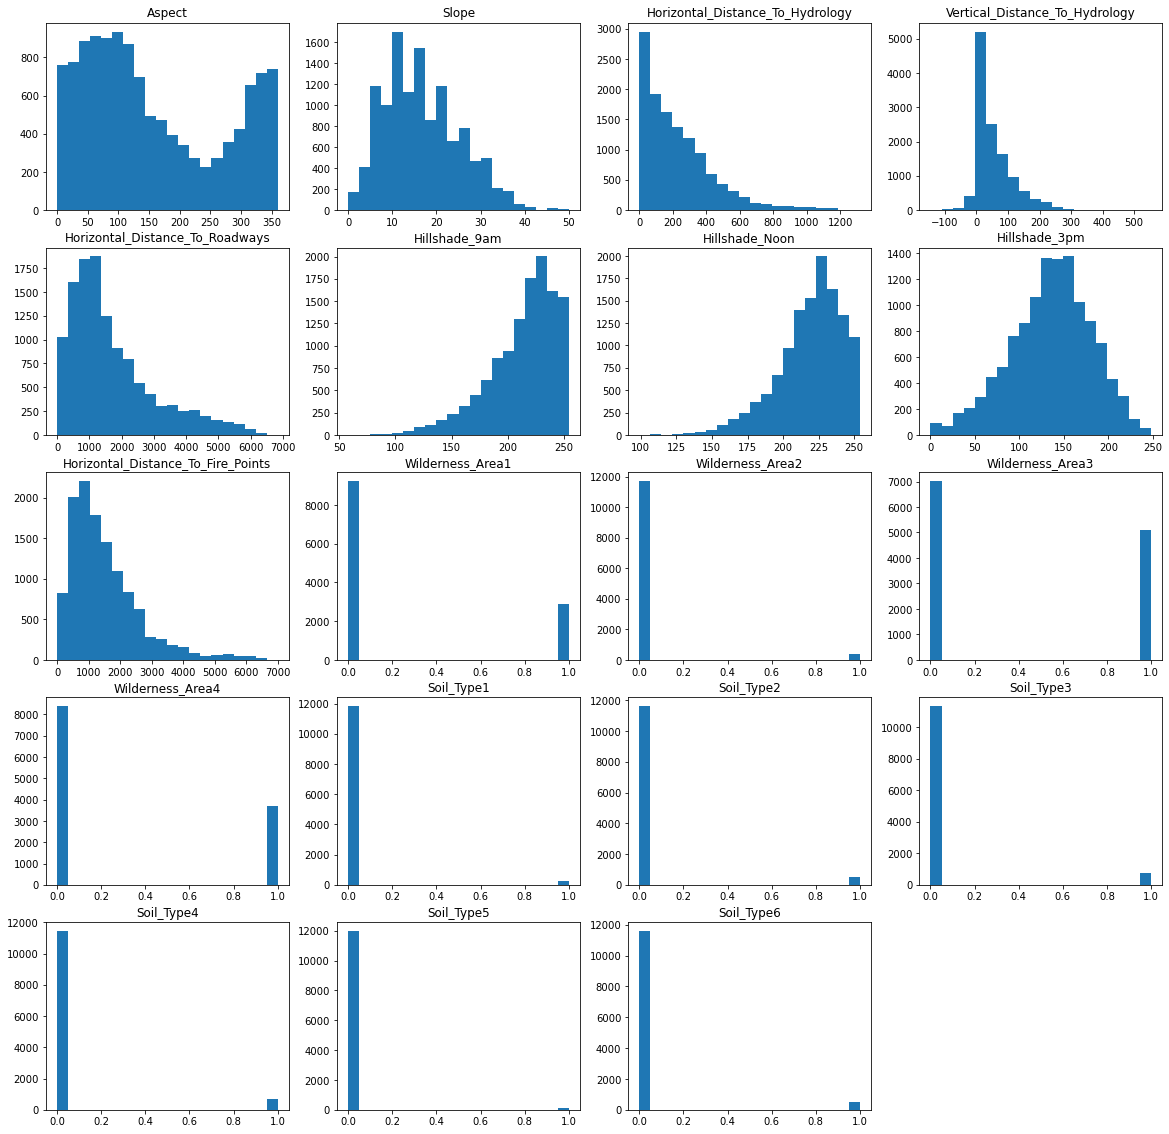

In [7]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(20, 20))

feature_cols = train_df.columns.tolist()

# Iterate over some of the features, creating a subplot with a histogram for each one.
for feature in range(1,20): #train_data.shape[1]
    plt.subplot(5, 4, feature)
    plt.hist(train_data[:,feature], 20)
    plt.title(feature_cols[feature])

The variables outside of the wilderness and soil binary flags all have a generally nice distribution generally spread across their respective ranges. We anticipate the wilderness and soil variables to be relatively sparse and likely good candidates for dimensionality reduction.

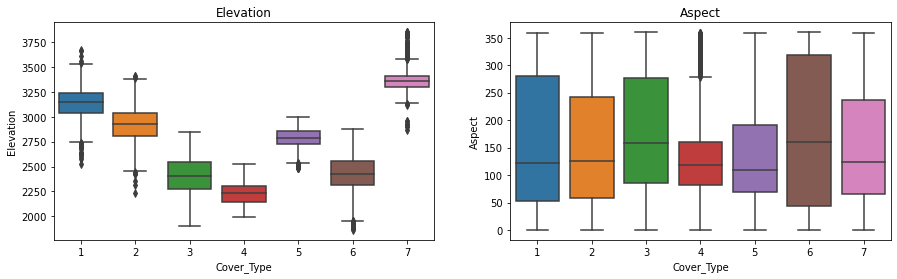

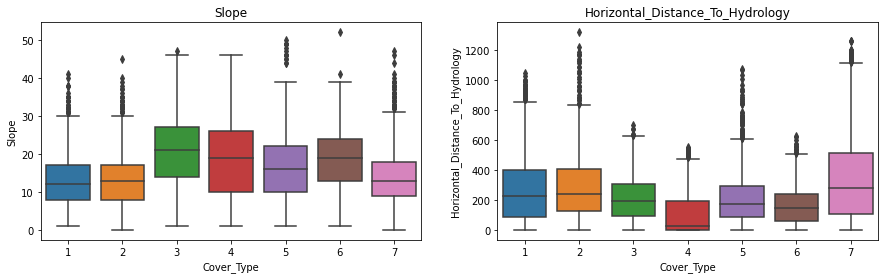

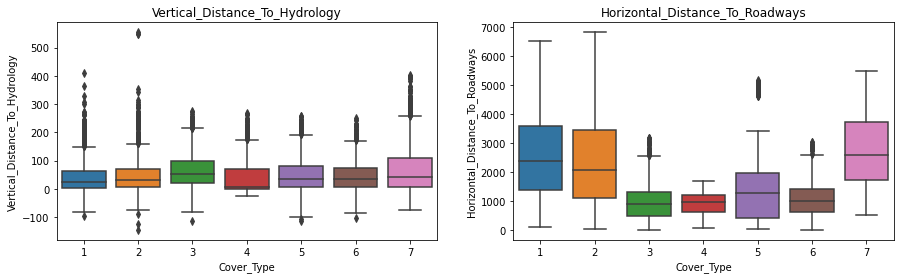

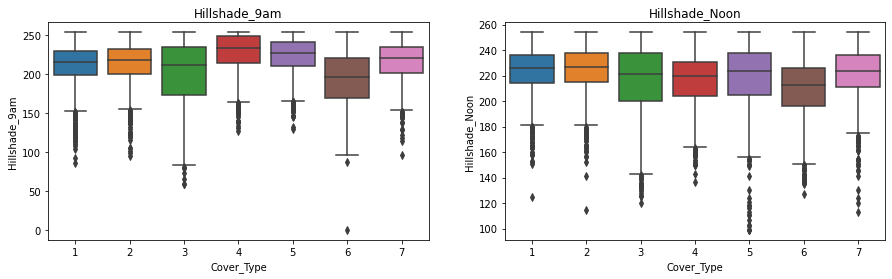

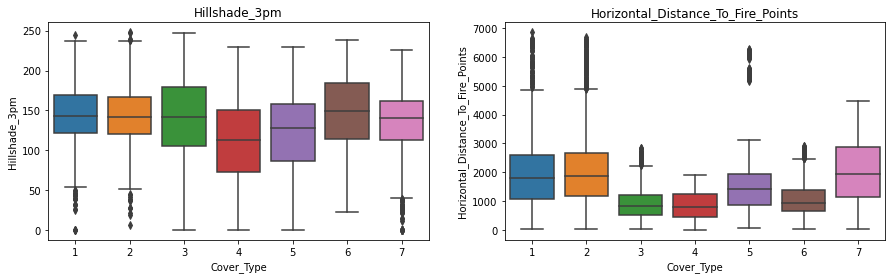

In [8]:
# plot boxplots of each cover type across first 10 feature values (excluding wilderness and soil type binary columns)

# columns to plot (2 columns plotted per row)
column_pairs_to_plot = [['Elevation','Aspect'],
                        ['Slope','Horizontal_Distance_To_Hydrology'],
                        ['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'],
                        ['Hillshade_9am','Hillshade_Noon'],
                        ['Hillshade_3pm','Horizontal_Distance_To_Fire_Points']]

# plot each boxplot
for column_pair in column_pairs_to_plot:
    
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 4))
    
    column_1 = column_pair[0]
    column_2 = column_pair[1]
    
    sns.boxplot(x='Cover_Type', y=column_1, data=train_df, ax = axs[0])
    axs[0].set_title(column_1)
    
    sns.boxplot(x='Cover_Type', y=column_2, data=train_df, ax = axs[1])
    axs[1].set_title(column_2)
    plt.show()

At first glance, elevation variable has the most variability across cover types. Some cover type pairs emerge with similar characteristics. For example, cover type 1 & 2 seem to have similar thresholds in addition cover types 3 & 4. 

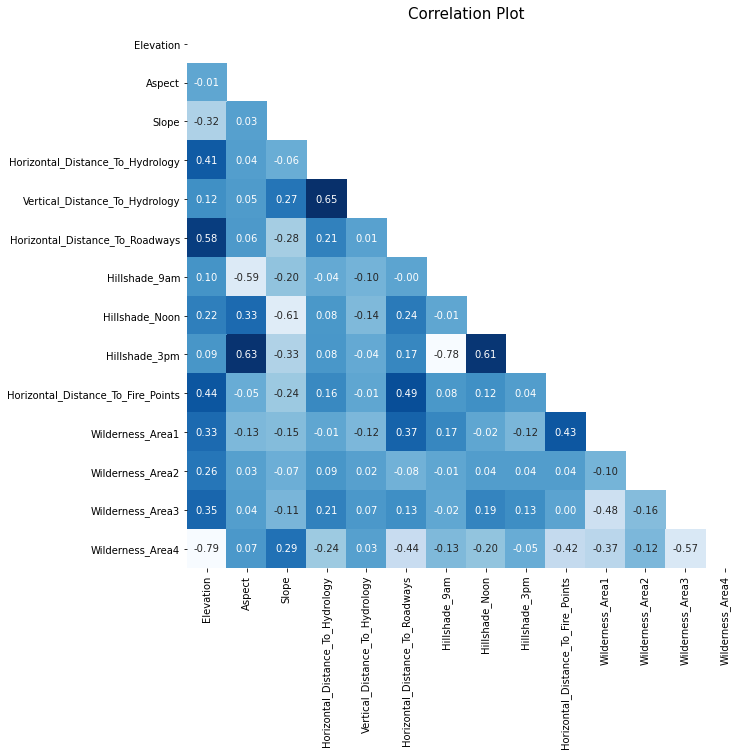

In [9]:
# correlation plot
corr = train_df.iloc[:, :14].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

No extreme intercorellation among features, but several coefficients with an absolute value above 0.5. There might be a benefit to use dimensionality reduction or other types of feature engineering to consolidate the features. 

### Plot Binary Variables

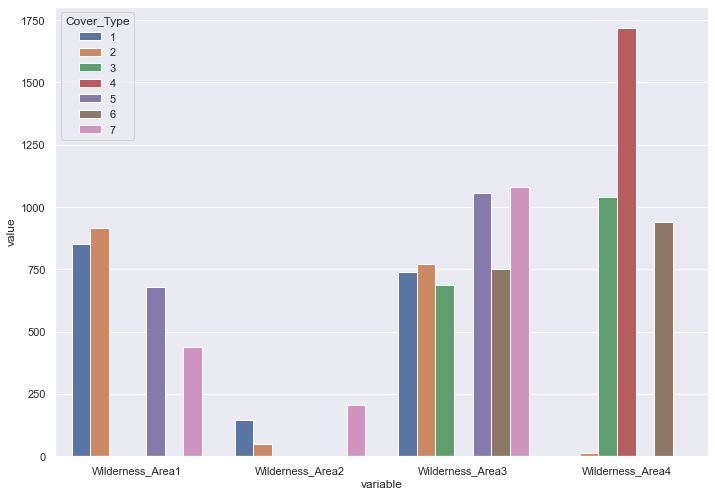

In [10]:
# sumarize counts per wilderness flag per cover type  

# get wilderness columns
wild_cols = [col for col in train_df.columns if 'Wilderness' in col]
wild_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
wilderness_cover_type = train_df[wild_cols].groupby(['Cover_Type']).sum()
wilderness_cover_type = wilderness_cover_type.reset_index()

# make table longer for easier plotting
wilderness_cover_type = pd.melt(wilderness_cover_type, id_vars=['Cover_Type'])

# Plot wilderness counts
sns.set(rc={'figure.figsize':(11.7,8.27)})   
sns.barplot(x='variable', y='value', hue="Cover_Type", data=wilderness_cover_type)
plt.show()

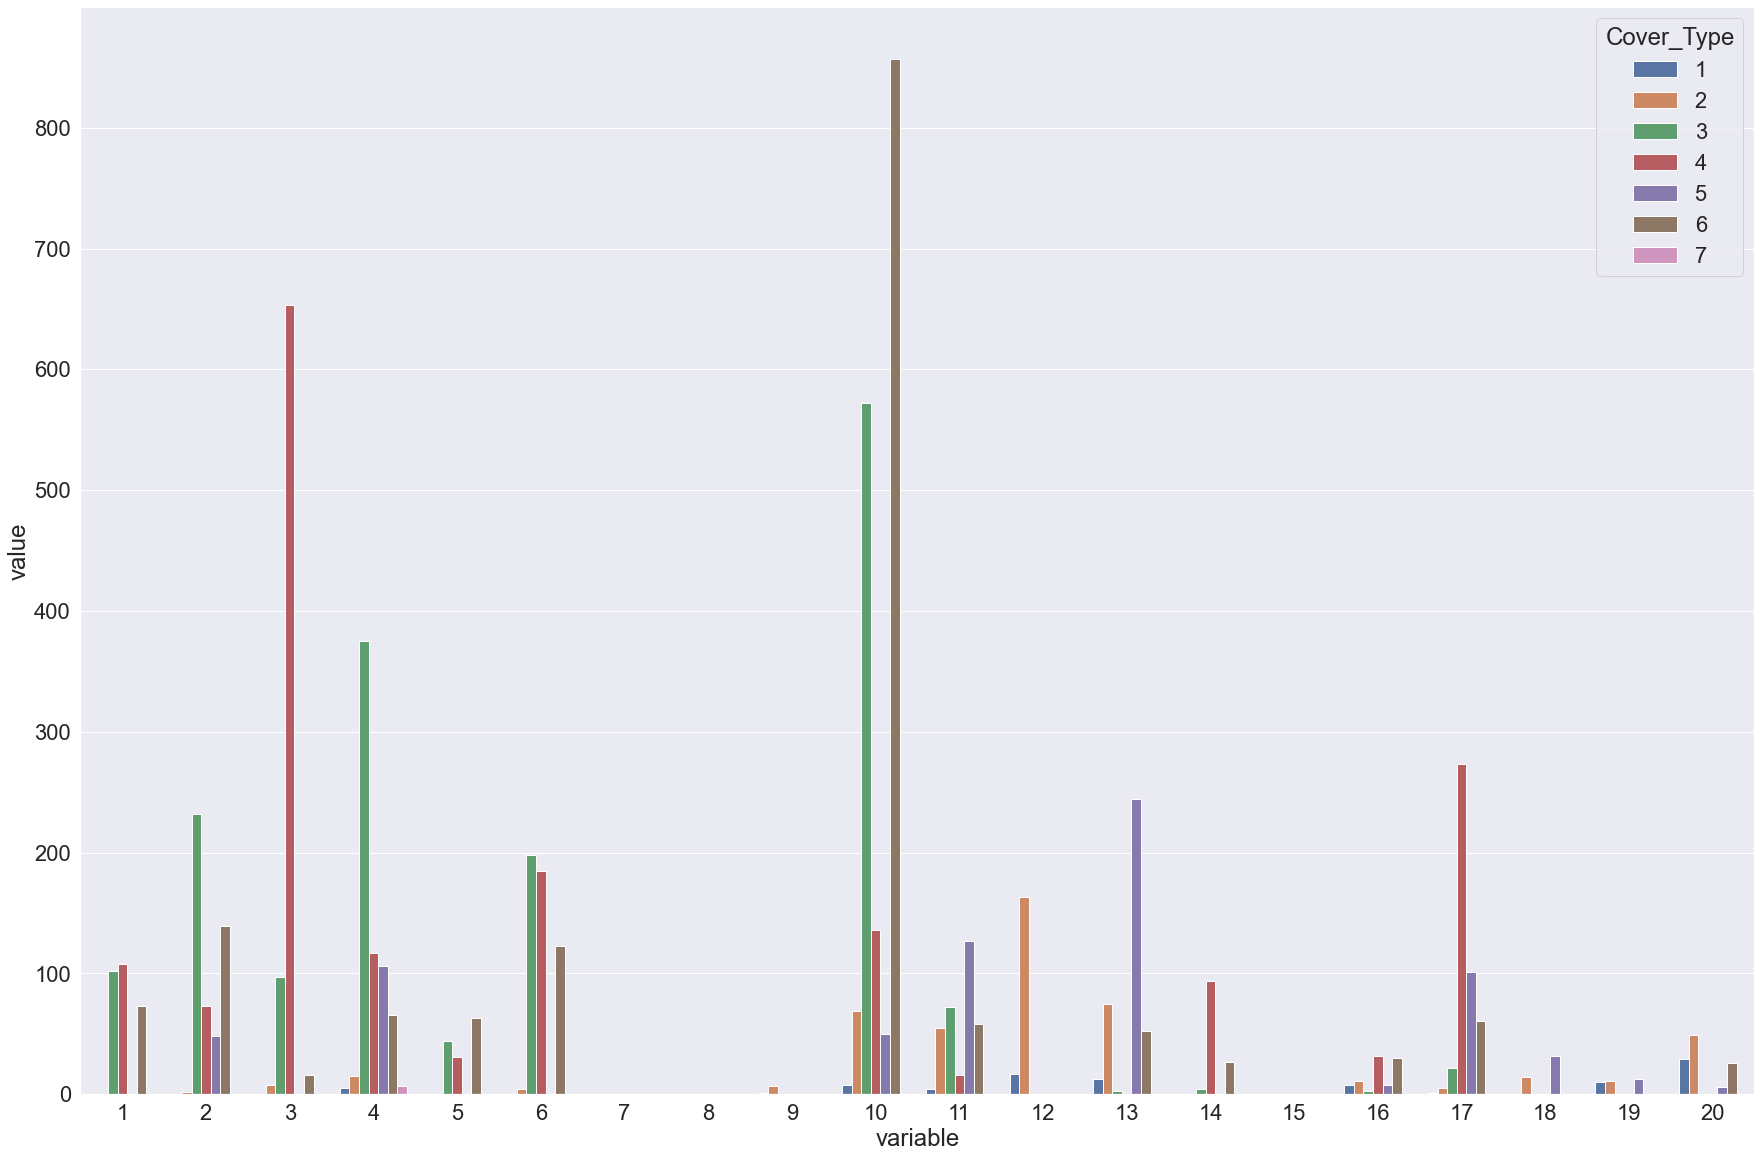

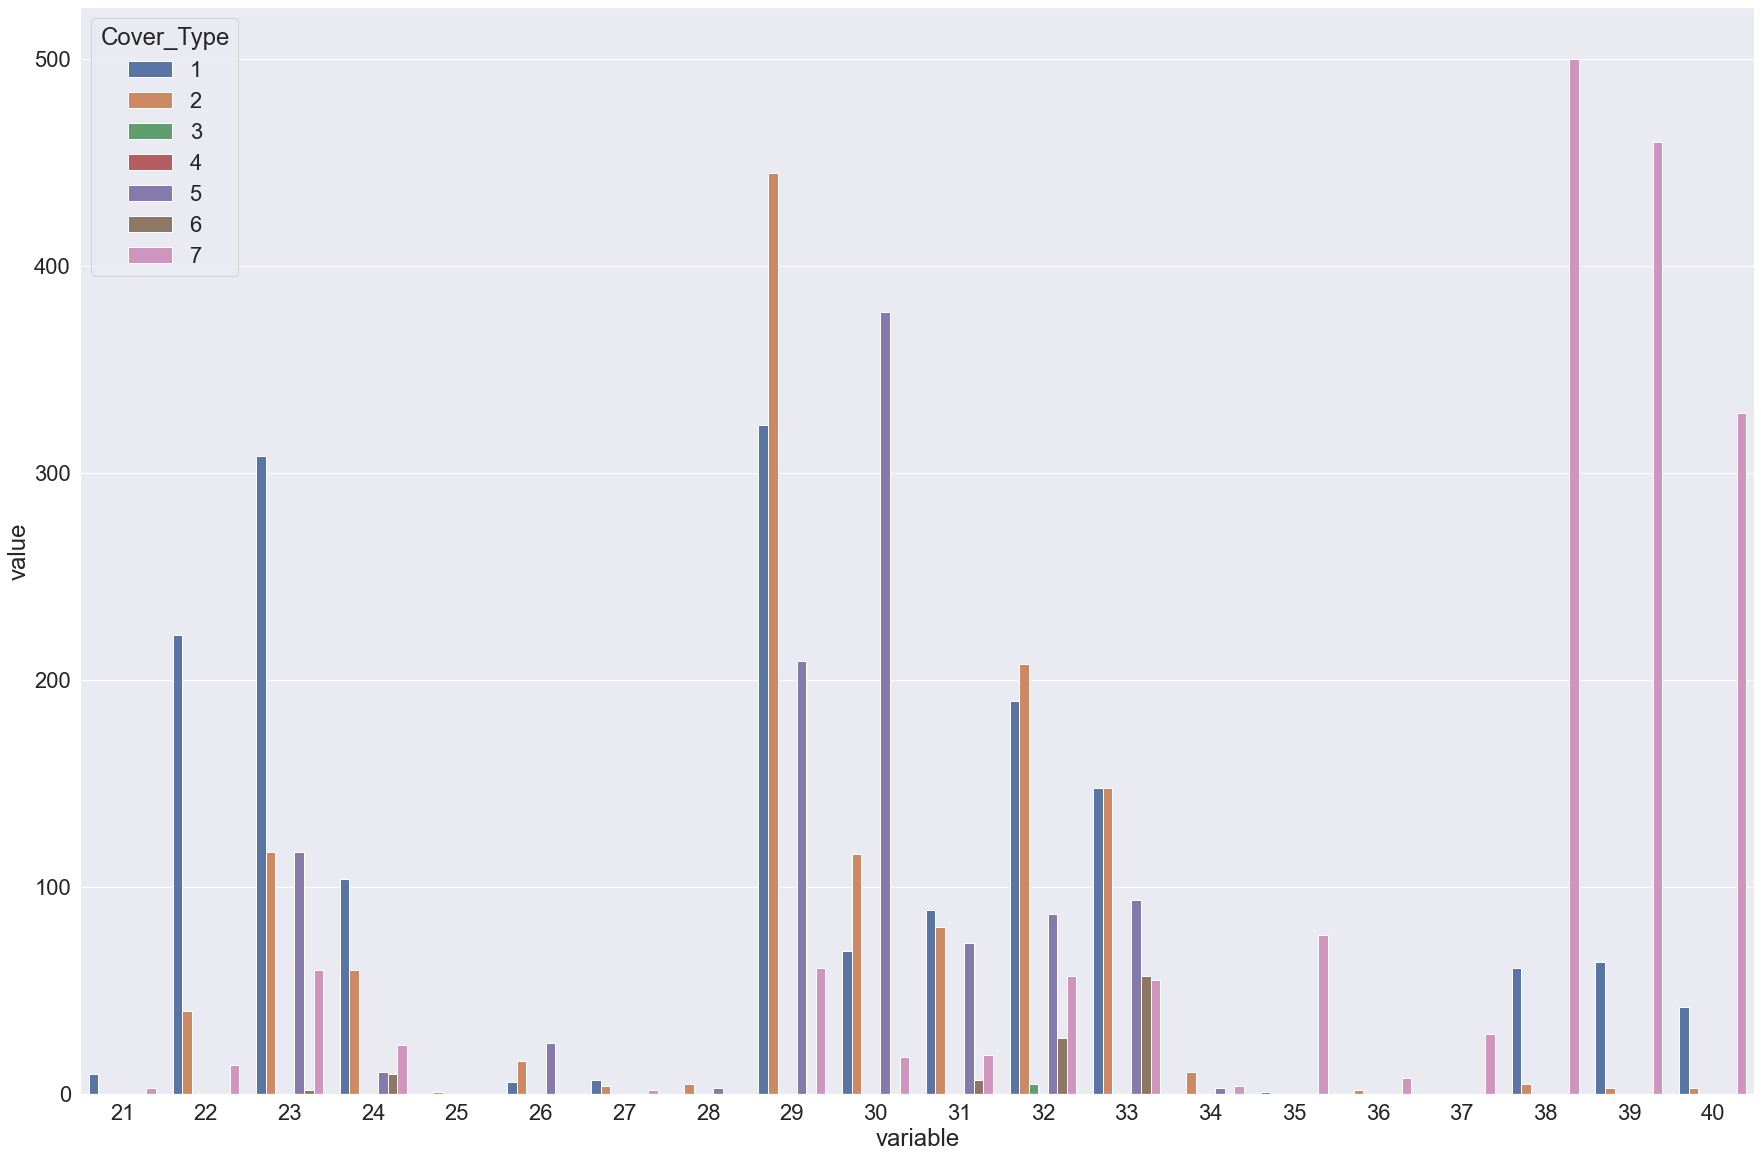

In [11]:
# sumarize counts per soil flag per cover type  

# get soil columns
soil_cols = [col for col in train_df.columns if 'Soil' in col]
soil_cols += ['Cover_Type']

# summarize wilderness column counts by cover type
soil_cover_type = train_df[soil_cols].groupby(['Cover_Type']).sum()
soil_cover_type = soil_cover_type.reset_index()

# make long format
soil_cover_type = pd.melt(soil_cover_type, id_vars=['Cover_Type'])

# remove text from soil_type and extract integer value
soil_cover_type['variable'] = soil_cover_type['variable'].str.extract('(\d+)').astype(int)

soil_cover_type_1 = soil_cover_type[soil_cover_type['variable'] <= 20]
soil_cover_type_2 = soil_cover_type[soil_cover_type['variable'] > 20]


# plotting; separate in 2 due to high number of columns
# plot 1
sns.set(rc={'figure.figsize':(30,20)}, font_scale = 2)  
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_1)
plt.show()

# plot 2
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_2)
plt.show()

The frequency counts highlight the sparsity of the binary flags, but also show some patterns where certain cover types are concentrated across specific ones. For instance, wilderness area 4 is primarily cover type 4. Another example is how cover type 7 largely has soil types 36-40. 

______________________________________________________________________________________________________________________

# 3) Baseline Models

We initially tested 6 different classifiers. For each we fit the model on the `train_data` and generalized on the `dev_data`. The `test_data` from the kaggle website doesn't contain any class labels.

Classifiers we used include;
- k-NN
- Logistic Regression
- Naive Bayes (Bernoulli & Gaussian)
- Random Forest
- Extra Trees

Model,Accuracy
Random Forest,84.523810
Knn,79.761905
Bernoulli Naive Bayes,60.052910
Gaussian Naive Bayes,59.027778
Logistic Regression,50.297619



K-Nearest Neighbors Confusion Matrix


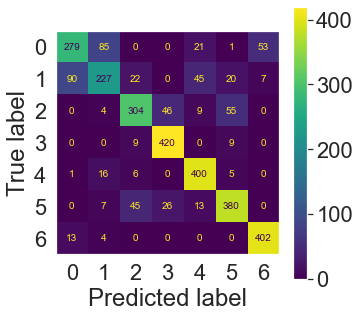

Logistic Regression Confusion Matrix


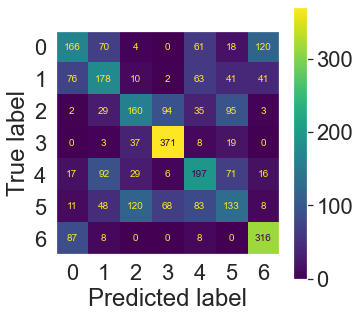

Bernoulli Naive Bayes Confusion Matrix


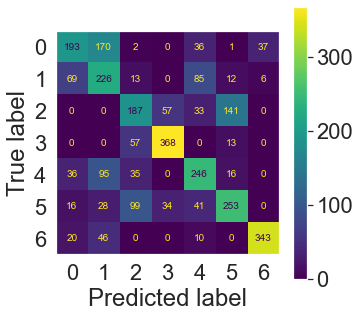

Gaussian Naive Bayes Confusion Matrix


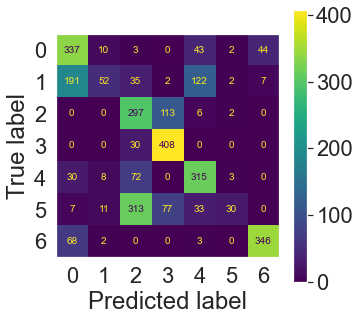

Random Forest Confusion Matrix


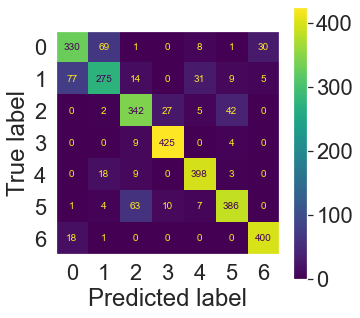

In [16]:
def plot_confusion_matrix(dev_labels, pred_labels):
    """
    Function that displays a confusion matrix for provided true and predicted classes
    """
    #print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(dev_labels, pred_labels))[:2])}')

    cm = confusion_matrix(dev_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,5))
    disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
    plt.grid(False)
    plt.show()
    return

def baseline_models(
    train_data=train_data, 
    train_labels=train_labels, 
    dev_data=dev_data, 
    dev_labels=dev_labels,
    show_confusion_matrix=True,
    show_accuracy_dataframe=True):
    """
    Function that trains and makes predictions using 5 of the classifiers went over during the class.
    Meant as a helper function for easier testing of different modeling pipelines.
    """

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(train_data, train_labels)
    accuracy_knn = (knn.score(dev_data, dev_labels)*100)
    pred_labels_knn  = knn.predict(dev_data)

    # Logistic Regression
    lm = LogisticRegression() 
    lm.fit(train_data, train_labels)
    accuracy_lr = (lm.score(dev_data, dev_labels)*100)
    pred_labels_lr  = lm.predict(dev_data)
        
    # Bernoulii Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(train_data, train_labels)
    accuracy_bnb = (bnb.score(dev_data, dev_labels)*100)
    pred_labels_bnb  = bnb.predict(dev_data)
        
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    accuracy_gnb = (gnb.score(dev_data, dev_labels)*100)
    pred_labels_gnb  = gnb.predict(dev_data)

    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
    accuracy_rf = (rf.score(dev_data, dev_labels)*100)
    pred_labels_rf  = rf.predict(dev_data)
    predictions_posterior_rf = rf.predict_proba(dev_data)

    
    # make dataframe with accuracies
    accuracies = {
        'Model' : ['Knn','Logistic Regression', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes' ,'Random Forest'],
        'Accuracy' : [accuracy_knn, accuracy_lr, accuracy_bnb, accuracy_gnb, accuracy_rf]
    }
    accuracies = pd.DataFrame(accuracies).sort_values('Accuracy',ascending=False)
    
    if show_accuracy_dataframe:
        display(accuracies.style.set_table_attributes('style="font-size: 17px"').hide_index())
    
    if show_confusion_matrix:
        print('\nK-Nearest Neighbors Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_knn)
        print('Logistic Regression Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_lr)
        print('Bernoulli Naive Bayes Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_bnb)
        print('Gaussian Naive Bayes Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_gnb)
        print('Random Forest Confusion Matrix')
        plot_confusion_matrix(dev_labels, pred_labels_rf)

    
    return accuracies

baseline_accuracies = baseline_models()

### Accuracy Comparison

The baseline models performed fairly well with accuracies as high as 86%. We chose accuracy as our performance metric because we did not have any reason to believe whether a false positive or false negative is more meaninful for the business problem. There also is an even proportion of class types within the data set so we do not believe the accuracy will be misleading by simply predicting the majority class each time.

Notably, there is a large variance across model accuracy with the worst classifer, logistic regression, reporting an accuracy of 38%. We believe this shows the non-linear nature of the data and how different cover types vary. Naive bayes performs better, with an accuracy of 60-65% but probably performs worse given the naive independence of feature assumption. Knn, Random Forest, & Extra Trees perform the best with accuracies of 80-86%. We hypothesize they perform better as they can model complex non-linear relationships. Random forest & extra trees might be performing better because of the high number of features (~50).

### Error Analysis

Note, the confusion matrix increments the class labels starting at 0. There isn't actually a cover_type=0, hence 0 in the confusion matrix actually corresponds to cover_type=1.

The confusion matrix shows two pairs of commonly confused classes. Classes 1 & 2 as well as classes 3 & 6 seem to be getting mixed up the most. Looking at the boxplots above we can see those pairs are very similar across the features which is likely why the model is getting confused. We plan to tweak our model in a way to try and improve classification across these classes.

### Next Steps

Given the performance of the baseline models we plan to prioritize optimization on the k-NN, random forest, and extra trees classifiers. We still plan to check how various optimization strategies improve upon performance of logistic regression and naive bayes classifiers. We plan to approach model optimization across three sections;

1.  Feature selection/engineering
    + None of our team members have any domain knowledge on the space. We expect that there is an opportunity to build new features using a combination of the existing ones, but will prioritize our time elsewhere. 
    + Dimensionality reduction: We will focus on trying to reduce the number of features (using PCA). The binary flags for wilderness and soil are notably sparse which play a big motivating factor of why we want to test this approach.
    

2. Ensemble methods
    + We will test building a stage based ensemble of models that tries to improve upon commonly confused classes (noted in the error analysis section). The first model will act similar to the baseline models, but if the first model predicts one of the confused classes we will use a subsequent model. The subsequent model will be trained on solely the confused classes in a hope to better fit the subtle differences among those. For example, the subsequent model will be only trained on classes 0 & 1 and will only be used if the first model predicts a 0 or 1. 
    + Random forest and extra trees are by nature ensemble based classifiers. They already have the best performance which we think can be partially a result of their nature of combining multiple models. We will try and use the predict_proba methods and test different permutations of ensumbles across the clasffiers and use the predition from the model that is the most confident. 

    
3. Hyperparameters
    + We plan to test various hyperparamters across the classifiers using a grid search cross validation to see if reducing complexity will improve accuracy during the generalize step.
    
______________________________________________________________________________________________________________________

# 4) Generalize Step Optimization

### Feature Selection/Engineering

We plan to test out model performance after applying some pre-processing to the feature data. Specifically, we will test normalizing the non-binary fields as well as applying dimensionality reduction techniques (PCA & Sparce PCA on all or a subset of features). We'll use the baseline models to benchmark on whether these feature engineering steps improve accuracy. 

*Note, sparse PCA works similarly as PCA, but drops certain less important features before performing PCA.*

#### Determine Number of Principle Components to Explore

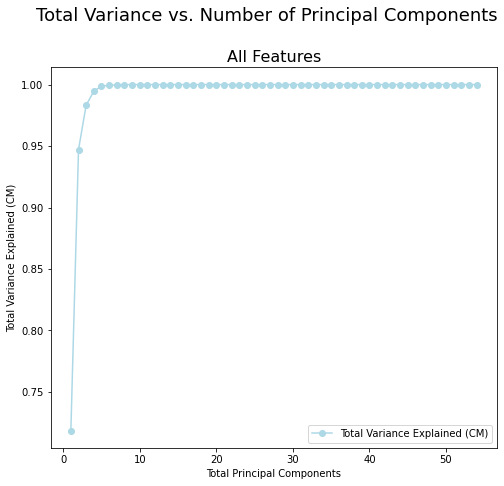

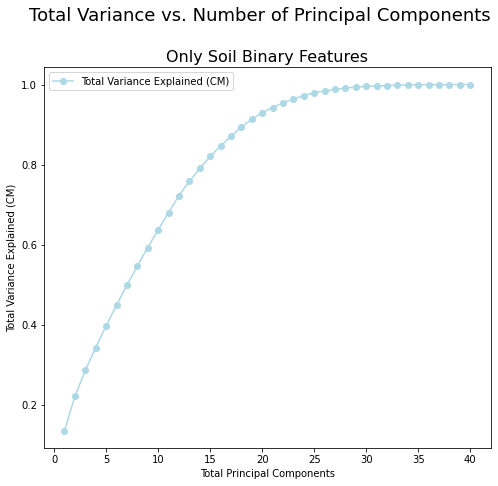

In [17]:
def calculate_explained_variance(dataset,title_text):
    """
    Function that trains a PCA model and plots the cumulative explained variance for each component.
    """
    
    max_n = dataset.shape[1]

    # fit PCA classifier with 50 components
    pca = PCA(n_components=max_n)
    pca.fit(dataset)

    # create dataframe to show explained variance
    principal_components = pd.DataFrame()
    principal_components['k'] = list(range(1,max_n+1))
    principal_components['explained_variance_ratio'] = pca.explained_variance_ratio_
    principal_components['explained_variance_ratio_cm'] = principal_components['explained_variance_ratio'].cumsum()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    # plotting

    # make figure and axis object
    fig,ax = plt.subplots(figsize = (8,7))

    # plot
    ax.plot(principal_components['k'], 
            principal_components['explained_variance_ratio_cm'], 
            color="lightblue", 
            marker="o", 
            label = 'Total Variance Explained (CM)')

    # sanitize graph
    ax.legend()
    ax.set_xlabel('Total Principal Components')
    ax.set_ylabel('Total Variance Explained (CM)')
    plt.suptitle('Total Variance vs. Number of Principal Components',fontsize=18, y=1)
    plt.title(title_text,fontsize=16, y=1)
    plt.show()
    pass
    
# make plot for all features
calculate_explained_variance(train_data,title_text='All Features')

# make plot for just soil features (will be tested in subsequent section)
# first binary column index
idx = train_df.columns.tolist().index('Soil_Type1')
calculate_explained_variance(train_data[:,idx:],title_text='Only Soil Binary Features')

The plots above show the total variance explained as we increase the number of principal components. The top plot applies PCA on all ~50 features while the bottom plot only applies it on the binary flag variables. The bottom plot shows the true sparcity of the binary flags as we need at least 20 components to explain 90% of the variance when subsetting to the those columns. The top plot shows near 100% of the variance can be explained by 5 components when including the entire feature space. This could indicate the non-binary flags are much more predictive.

#### Functions To Explore Pre-Processing Methods

In [17]:
def split_soil_type_features(dataset):
    """
    Function that splits dataset into 2 arrays; one with features excluding soil 
    flags & one with only soil flag features.
    """
    # get feature indexes for Soil_Types
    other_idx = [i for i, col in enumerate(train.columns) if not 'Soil' in col and 'Cover' not in col]
    soil_type_idx = [i for i, col in enumerate(train.columns) if 'Soil' in col]
    
    soil_type_features = dataset[:, soil_type_idx]
    other_features = dataset[:, other_idx]
    
    return other_features, soil_type_features

def spca_n_comp_trials(train_data=train_data, 
                       train_labels=train_labels, 
                       dev_data=dev_data, 
                       dev_labels=dev_labels,
                       split_features=True):
    """
    Function that runs through a loop and calls the baseline models function after performing Sparse PCA
    on the feature data. The # of components tested are based on the explained variance distribution plots above.
    """
    
    # initial empty dataframe which will have all different accuracy permutations
    model_accuracy = pd.DataFrame(columns = ['Model','Accuracy','n_components','alpha'])
    
    if split_features:
        n_comp_list = [2,5,10,30]
    else:
        n_comp_list = list(range(1,6))
    
    for alpha_set in [1,10,100]:
        for n_comp in n_comp_list:
            #print()
            #print('-'*25)
            #print(f'number of components = {n_comp}. alpha = {alpha_set}')
        
            if split_features == True:
                ##### transform train_data #####
                other_features, soil_type_features = split_soil_type_features(train_data)
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_soil_features = spca.fit_transform(soil_type_features)
                spca_transformed_train_data = np.concatenate((other_features, spca_soil_features), axis=1)

                ##### transform dev_data #####
                other_features, soil_type_features = split_soil_type_features(dev_data)
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_soil_features = spca.fit_transform(soil_type_features)
                spca_transformed_dev_data = np.concatenate((other_features, spca_soil_features), axis=1)
            else:
                ##### transform train_data #####
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_transformed_train_data = spca.fit_transform(train_data)

                ##### transform dev_data #####
                spca = SparsePCA(n_components = n_comp, alpha=alpha_set, tol=0.1) # always done now, depreciated #, normalize_components=True)
                spca_transformed_dev_data = spca.fit_transform(dev_data)
            
            # store accuracies
            accuracies = baseline_models(
                            train_data=spca_transformed_train_data, 
                            train_labels=train_labels, 
                            dev_data=spca_transformed_dev_data,
                            dev_labels=dev_labels,
                            show_confusion_matrix=False,
                            show_accuracy_dataframe=False
                         )
            
            # add into main dataframe to enable visualization of different hyperparams
            accuracies['n_components'] = n_comp
            accuracies['alpha'] = alpha_set
            model_accuracy = model_accuracy.append(accuracies)
            
    return model_accuracy


def pca_n_comp_trials(train_data=train_data, 
                      train_labels=train_labels, 
                      dev_data=dev_data, 
                      dev_labels=dev_labels,
                      split_features=True):
    """
    Function that runs through a loop and calls the baseline models function after performing PCA
    on the feature data. The # of components tested are based on the explained variance distribution plots above.
    """
    
    # initial empty dataframe which will have all different accuracy permutations
    model_accuracy = pd.DataFrame(columns = ['Model','Accuracy','n_components'])
    
    if split_features:
        n_comp_list = [2,5,10,30]
    else:
        n_comp_list = list(range(1,6))
    
    for n_comp in n_comp_list:
        #print()
        #print('-'*25)
        #print(f'number of components = {n_comp}')

        if split_features == True:
            ##### transform train_data #####
            other_features, soil_type_features = split_soil_type_features(train_data)
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_soil_features = pca.fit_transform(soil_type_features)
            pca_transformed_train_data = np.concatenate((other_features, pca_soil_features), axis=1)

            ##### transform dev_data #####
            other_features, soil_type_features = split_soil_type_features(dev_data)
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_soil_features = pca.fit_transform(soil_type_features)
            pca_transformed_dev_data = np.concatenate((other_features, pca_soil_features), axis=1)
        else:
            ##### transform train_data #####
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_transformed_train_data = pca.fit_transform(train_data)

            ##### transform dev_data #####
            pca = PCA(n_components = n_comp) # always done now, depreciated #, normalize_components=True)
            pca_transformed_dev_data = pca.fit_transform(dev_data)

        
        # store accuracies
        accuracies = baseline_models(
                        train_data=pca_transformed_train_data, 
                        train_labels=train_labels, 
                        dev_data=pca_transformed_dev_data,
                        dev_labels=dev_labels,
                        show_confusion_matrix=False,
                        show_accuracy_dataframe=False
                     )

        # add into main dataframe to enable visualization of different hyperparams
        accuracies['n_components'] = n_comp
        model_accuracy = model_accuracy.append(accuracies)
            
    return model_accuracy

def normalize_values(dataset, scaler_type='StandardScaler'):
    """
    Function that normalizes the non binary feature data
    """
    
    # the index of first binary flag column
    idx = train_df.columns.tolist().index('Wilderness_Area1')
    
    # array of features to normalize (all columns except binary flag ones)
    dataset_to_norm = dataset[:,:idx]
    
    # array of features to keep as is
    dataset_to_keep_as_is = dataset[:,idx:]
    
    # create standard scaler object
    if scaler_type == 'StandardScaler':
        normer = preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        normer = preprocessing.MinMaxScaler()
    elif scaler_type == 'Normalizer':
        normer = preprocessing.Normalizer()

    dataset_norm = normer.fit_transform(dataset_to_norm)
        
    # consolidate
    dataset_new = np.column_stack((dataset_norm,dataset_to_keep_as_is))

    return dataset_new

def preprocessing_methods(train_data,
                          train_labels,
                          dev_data,
                          dev_labels,
                          dataframe_caption = 'Maxiumum Accuracy Per Model'):
    """
    Function that tests different pre-processing method permutations of using both PCA & normalizing values.
    Creates a final summary dataframe that combines the results from all methods and shows the best methods per model.
    """

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    # generate accuracy results across various preprocessing steps

    # normalized arrays
    train_data_norm = normalize_values(train_data, scaler_type = 'StandardScaler')
    dev_data_norm = normalize_values(dev_data, scaler_type = 'StandardScaler')

    # baseline (w/out normalizing) -- already exists in memory
    # baseline_accuracies 

    # baseline (w/ normalizing)
    baseline_accuracies_norm       = baseline_models(train_data=train_data_norm,
                                                     train_labels=train_labels,
                                                     dev_data=dev_data_norm,
                                                     dev_labels=dev_labels,
                                                     show_confusion_matrix=False,
                                                     show_accuracy_dataframe=False)

    # spca (w/out normalizing)
    model_accuracy_spca_split      = spca_n_comp_trials(train_data=train_data,
                                                        train_labels=train_labels,
                                                        dev_data=dev_data,
                                                        dev_labels=dev_labels,
                                                        split_features=True)

    model_accuracy_spca            = spca_n_comp_trials(train_data=train_data,
                                                        train_labels=train_labels,
                                                        dev_data=dev_data,
                                                        dev_labels=dev_labels,
                                                        split_features=False)

    # pca (w/out normalizing)
    model_accuracy_pca_split       = pca_n_comp_trials(train_data=train_data,
                                                       train_labels=train_labels,
                                                       dev_data=dev_data,
                                                       dev_labels=dev_labels,
                                                       split_features=True)

    model_accuracy_pca             = pca_n_comp_trials(train_data=train_data,
                                                       train_labels=train_labels,
                                                       dev_data=dev_data,
                                                       dev_labels=dev_labels,
                                                       split_features=False)

    # spca (w/ normalizing)
    model_accuracy_spca_split_norm = spca_n_comp_trials(train_data=train_data_norm,
                                                        train_labels=train_labels,
                                                        dev_data=dev_data_norm,
                                                        dev_labels=dev_labels,
                                                        split_features=True)

    model_accuracy_spca_norm       = spca_n_comp_trials(train_data=train_data_norm,
                                                        train_labels=train_labels,
                                                        dev_data=dev_data_norm,
                                                        dev_labels=dev_labels,
                                                        split_features=False)

    # pca (w/ normalizing)
    model_accuracy_pca_split_norm = pca_n_comp_trials(train_data=train_data_norm,
                                                      train_labels=train_labels,
                                                      dev_data=dev_data_norm,
                                                      dev_labels=dev_labels,
                                                      split_features=True)

    model_accuracy_pca_norm       = pca_n_comp_trials(train_data=train_data_norm,
                                                      train_labels=train_labels,
                                                      dev_data=dev_data_norm,
                                                      dev_labels=dev_labels,
                                                      split_features=False)


    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    # combine dataframes into one to summarize metrics easily

    baseline_accuracies['Pre-Processing Method']            = 'Baseline'
    model_accuracy_spca_split['Pre-Processing Method']      = 'Sparse PCA on Soil Features'
    model_accuracy_spca['Pre-Processing Method']            = 'Sparse PCA on All Features'
    model_accuracy_pca_split['Pre-Processing Method']       = 'PCA on Soil Features'
    model_accuracy_pca['Pre-Processing Method']             = 'PCA on All Features'

    baseline_accuracies_norm['Pre-Processing Method']       = 'Baseline (w/ normalizing)'
    model_accuracy_spca_split_norm['Pre-Processing Method'] = 'Sparse PCA on Soil Features (w/ normalizing)'
    model_accuracy_spca_norm['Pre-Processing Method']       = 'Sparse PCA on All Features (w/ normalizing)'
    model_accuracy_pca_split_norm['Pre-Processing Method']  = 'PCA on Soil Features (w/ normalizing)'
    model_accuracy_pca_norm['Pre-Processing Method']        = 'PCA on All Features (w/ normalizing)'

    columns = ['Model','Pre-Processing Method','Accuracy']
    model_accuracy_all = pd.concat([baseline_accuracies,
                                    model_accuracy_spca_split,
                                    model_accuracy_spca,
                                    model_accuracy_pca_split,
                                    model_accuracy_pca,
                                    baseline_accuracies_norm,
                                    model_accuracy_spca_split_norm,
                                    model_accuracy_spca_norm,
                                    model_accuracy_pca_split_norm,
                                    model_accuracy_pca_norm])
    model_accuracy_all = model_accuracy_all[columns]

    
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    # wrangle data and print results
    
    # create pivot table that shows the best accuracy (across all preprocessing method)
    performance_summary = pd.pivot_table(model_accuracy_all, 
                                         values='Accuracy', 
                                         index='Pre-Processing Method', 
                                         columns='Model', 
                                         aggfunc=np.max)
    # add (max) to all the column
    cols = performance_summary.columns
    performance_summary.columns = [col + ' (Max)' for col in cols]

    # append one column that is the median accuracy (across all models) for each method
    performance_summary_med = model_accuracy_all.groupby(['Pre-Processing Method']).median().reset_index()
    performance_summary_med.columns = ['Method','All Models (Median)']
    performance_summary_med = performance_summary_med.set_index('Method')
    performance_summary = performance_summary.join(performance_summary_med)
    performance_summary = performance_summary.reset_index()

    # sort by median descending
    performance_summary = performance_summary.sort_values(by='All Models (Median)',ascending=False)

    # display final dataframe with color coded cells for column-wise maximum
    def highlight_max(x):
        return ['background-color: lightgreen;' if v == np.max(x) else '' for v in x]
    def bold_max(x):
        return ['font-weight: bold;' if v == np.max(x) else '' for v in x]

    # columns to apply formatting
    subset_cols = performance_summary.columns[1:][:-1]

    # format columns
    performance_summary = (performance_summary
                           .style
                           .apply(highlight_max, subset = subset_cols)
                           .apply(bold_max, subset = subset_cols))

    # add title and display
    styles = [dict(selector="caption", props=[("font-size", "120%"),
                                              ("font-weight", "bold")])]

    performance_summary = performance_summary.set_caption(dataframe_caption).set_table_styles(styles)
    display(performance_summary.hide_index())
    
    return performance_summary

# call function that builds the summary table
performance_summary = preprocessing_methods(train_data=train_data,
                                            train_labels=train_labels,
                                            dev_data=dev_data,
                                            dev_labels=dev_labels)

Pre-Processing Method,Bernoulli Naive Bayes (Max),Gaussian Naive Bayes (Max),Knn (Max),Logistic Regression (Max),Random Forest (Max),All Models (Median)
Baseline (w/ normalizing),62.070106,46.825397,77.777778,70.171958,84.689153,70.171958
PCA on Soil Features (w/ normalizing),48.346561,50.396825,75.628307,67.328042,82.572751,64.666005
Baseline,60.052910,59.027778,79.761905,50.297619,84.523810,60.052910
Sparse PCA on Soil Features (w/ normalizing),45.105820,47.585979,76.025132,67.625661,83.267196,59.126984
PCA on Soil Features,43.187831,61.044974,79.761905,50.264550,82.407407,55.654762
Sparse PCA on Soil Features,32.903439,56.117725,79.761905,50.231481,83.498677,50.082672
PCA on All Features,40.806878,50.429894,78.339947,51.719577,82.142857,40.806878
Sparse PCA on All Features,40.806878,50.892857,78.637566,51.984127,82.506614,40.641534
PCA on All Features (w/ normalizing),37.698413,44.874339,60.846561,51.190476,62.466931,37.698413
Sparse PCA on All Features (w/ normalizing),30.952381,38.062169,32.705026,36.574074,35.284392,25.099206


The above chart shows each model's performance across different preprocessing methods. We tested normalizing the non-binary fields as well as applying dimensionality reduction techniques (PCA & Sparce PCA on all or a subset of features). 

In the table above, each row represents a method, each column represents a specific model, and the data points represents a model's maximum accuracy recorded for that method. The final column appended at the end shows the median accuracy for that method across all models. This is meant to add a benchmark indicating which method performed the best.

The top models overall are consistent with results from our baseline analysis where Extra Trees, Random Forest, and knn performed the best. The best accuracy reported involved normalizing the training data. This makes sense as the kaggle description noted the values were not normalized, hence normalizing values helps balance incremental changes across feature values. Dimensionality reduction did better when only using it on the sparse binary flag data versus the entire feature set. We elected to not leverage PCA or Sparse PCA because of the slight reduction of accuracy. 

### Hyperparameters

fit accuracy: 0.8544972138613387
best parameters:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 150}
generalize accuracy: 0.8501984126984127


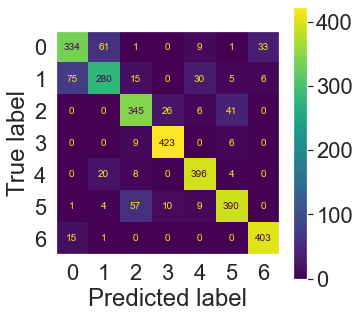

In [20]:
def param_search(classifier, 
                 train_data=normalize_values(train_data, scaler_type = 'StandardScaler'), 
                 train_labels=normalize_values(dev_data, scaler_type = 'StandardScaler'), 
                 dev_data=dev_data, 
                 dev_labels=dev_labels):
    """
    Function that performs a grid search cross validation on a random forest classifer.
    """
    
    # parameters to test
    parameters = {
        'n_estimators': list(range(50,201,50)),
        'max_features': ['auto', None, 'log2'],
        'max_depth' : [None, 400, 500, 600],
        'criterion' :['entropy', 'gini'],
    }

    if classifier == 'RandomForest':
        model = RandomForestClassifier(random_state=0)
    else:
        raise Exception('Not a valid classifier')

    gs = GridSearchCV(model, parameters, n_jobs=-1, scoring='accuracy').fit(train_data, train_labels)

    print(f'fit accuracy: {gs.best_score_}')
    print(f'best parameters:\n{gs.best_params_}')

    pred = gs.best_estimator_.predict(dev_data).astype(int)

    ###generate accuracy
    accuracy_count = 0
    for j in range(dev_labels.shape[0]):
        if pred[j] == dev_labels[j]:
            accuracy_count += 1
        else:
            continue

    print(f'generalize accuracy: {accuracy_count/pred.shape[0]}')


    plot_confusion_matrix(dev_labels, pred)

    
# call function
param_search('RandomForest')


Random Forest accuracy = 85.01984126984127


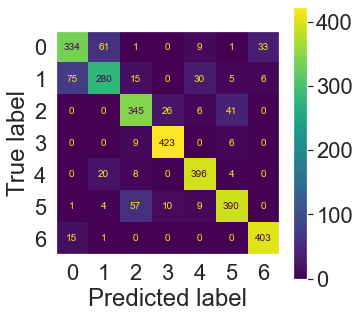

cover type 1 and type 2 total correct 614


In [22]:
def random_forest_optimized(train_data=normalize_values(train_data, scaler_type = 'StandardScaler'), 
                            train_labels=train_labels, 
                            dev_data=normalize_values(dev_data, scaler_type = 'StandardScaler'), 
                            dev_labels=dev_labels,
                            show_confusion_matrix=True):
    """
    A model that trains a random forest model with optimal hyperparameters based on grid search 
    cross validation. 
    """
    
    # Random Forest
    rf = RandomForestClassifier(
        criterion = 'entropy',
        max_depth = None,
        max_features = 'auto',
        n_estimators= 150,
        random_state=0
    )
    rf.fit(train_data, train_labels)
    print(f'\nRandom Forest accuracy = {(rf.score(dev_data, dev_labels)*100)}')
    pred_labels  = rf.predict(dev_data)
    if show_confusion_matrix == True:
        plot_confusion_matrix(dev_labels, pred_labels)
        
    print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(dev_labels, pred_labels))[:2])}')
        

# call function
random_forest_optimized(train_data=train_data_norm,dev_data=dev_data_norm)

When comparing both the baseline models as well as the models after some pre-processing the Random Forest model has consistently performed the best. In this section, we ran a cross validation grid search to find the optimal hyperparamters to maximize performance during the generalize step.

Random Forest Accuracy Metrics:
* Baseline Accuracy: 84.52%
* Accuracy After Normalizing Values: 84.69%
* Accuracy After Tuning Hyperparameters: 85.02%

Still the most confused class types paris remain classes 1 & 2 and classes 3 & 6. We subsequently will try to improve upon our current accuracy levels by building a multi stage ensemble model that focuses on the commonly confused classes.

### Ensemble Methods

The first type of ensemble we will try is to train additional models solely on the commonly misclassified pairs. For example we will have the primary model as developed in the prior steps. We will have two additional models where one is trained solely on classes 1 & 2 while the other is only on classes 3 & 6. If the first model predicts a 1 or 2 then the model trained on that subset will be used for the final prediction. The hypothesis is that the "subset" models will be better fit to the nuances between those classes.

First, we will rerun the pre-processing method grids for the subsets as well as the cross validation grid search to properly define the subset models.

In [50]:
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset([1,2])

# call function that builds the summary table
performance_summary = preprocessing_methods(train_data=train_data_subset,
                                            train_labels=train_labels_subset,
                                            dev_data=dev_data_subset,
                                            dev_labels=dev_labels_subset,
                                            dataframe_caption = 'Maxiumum Accuracy Per Model (Classes 1 & 2 Only)')

Pre-Processing Method,Bernoulli Naive Bayes (Max),Gaussian Naive Bayes (Max),Knn (Max),Logistic Regression (Max),Random Forest (Max),All Models (Median)
Baseline (w/ normalizing),75.411765,56.705882,76.941176,76.823529,80.588235,76.823529
PCA on Soil Features,56.117647,70.705882,75.764706,75.647059,78.000000,75.588235
Sparse PCA on Soil Features,53.294118,72.470588,75.764706,75.647059,79.882353,75.235294
Sparse PCA on Soil Features (w/ normalizing),75.176471,53.529412,77.058824,75.647059,80.117647,75.117647
PCA on Soil Features (w/ normalizing),75.411765,55.647059,77.647059,75.294118,78.352941,74.882353
Sparse PCA on All Features,71.058824,74.235294,76.000000,74.000000,75.529412,60.470588
PCA on All Features,69.882353,74.941176,76.000000,74.588235,78.823529,60.352941
Baseline,60.052910,59.027778,79.761905,50.297619,84.523810,60.052910
PCA on All Features (w/ normalizing),71.411765,72.235294,70.588235,72.705882,71.882353,55.882353
Sparse PCA on All Features (w/ normalizing),74.823529,73.764706,69.294118,72.352941,72.000000,51.647059


The random forest remains the superior model but there is better performance if the feature data is not normalized.

fit accuracy: 0.8112391930835734
best parameters:
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}
generalize accuracy: 0.8058823529411765


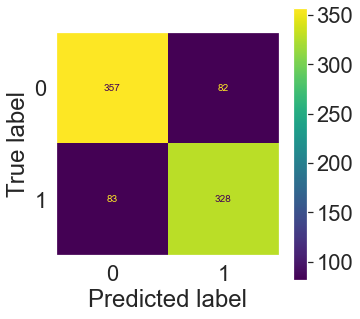

In [56]:
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset([1,2])

param_search('RandomForest',
             train_data=train_data_subset, 
             dev_data=dev_data_subset, 
             train_labels=train_labels_subset, 
             dev_labels=dev_labels_subset)

In [51]:
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset([3,6])

# call function that builds the summary table
performance_summary = preprocessing_methods(train_data=train_data_subset,
                                            train_labels=train_labels_subset,
                                            dev_data=dev_data_subset,
                                            dev_labels=dev_labels_subset,
                                            dataframe_caption = 'Maxiumum Accuracy Per Model (Classes 3 & 6 Only)')

Pre-Processing Method,Bernoulli Naive Bayes (Max),Gaussian Naive Bayes (Max),Knn (Max),Logistic Regression (Max),Random Forest (Max),All Models (Median)
Baseline (w/ normalizing),66.929134,54.105737,85.601800,70.866142,86.501687,70.866142
PCA on Soil Features (w/ normalizing),62.767154,69.066367,84.814398,70.078740,86.389201,69.403825
PCA on Soil Features,61.192351,68.953881,86.389201,65.579303,85.826772,67.154106
Sparse PCA on Soil Features (w/ normalizing),65.354331,69.628796,84.814398,70.416198,85.151856,66.591676
Sparse PCA on Soil Features,65.466817,69.628796,86.389201,65.579303,85.376828,65.241845
Baseline,60.052910,59.027778,79.761905,50.297619,84.523810,60.052910
PCA on All Features (w/ normalizing),58.717660,59.730034,77.052868,60.067492,77.840270,58.605174
PCA on All Features,55.343082,59.505062,58.717660,56.017998,63.442070,54.780652
Sparse PCA on All Features,48.931384,51.181102,56.242970,51.293588,55.793026,50.168729
Sparse PCA on All Features (w/ normalizing),51.293588,50.506187,60.292463,52.418448,59.392576,47.019123


The results are similar to the initial model were random forest with normalizing values has the best accuracy.

fit accuracy: 0.8842879634698546
best parameters:
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'n_estimators': 150}
generalize accuracy: 0.8785151856017998


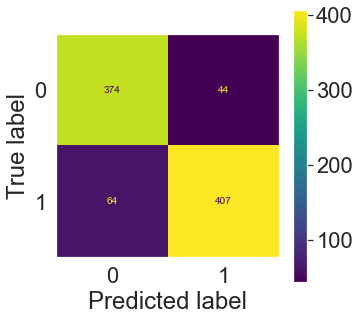

In [30]:
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset([3,6])

param_search('RandomForest',
             train_data=normalize_values(train_data_subset, scaler_type = 'StandardScaler'), 
             dev_data=normalize_values(dev_data_subset, scaler_type = 'StandardScaler'), 
             train_labels=train_labels_subset, 
             dev_labels=dev_labels_subset)

One stage accuracy: 85.01984126984127
Two stage accuracy: 84.52380952380952
Three stage accuracy: 84.39153439153439

One Stage Ensemble Confusion Matrix


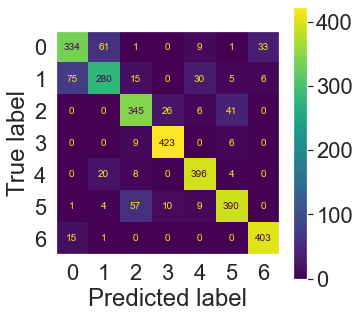


Two Stage Ensemble Confusion Matrix


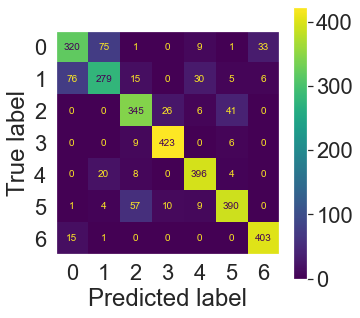


Three Stage Ensemble Confusion Matrix


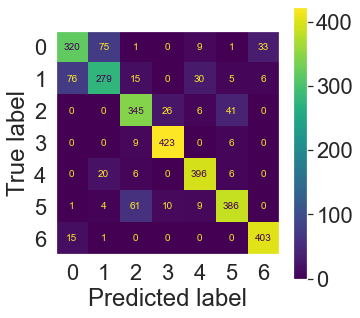

In [124]:
def ensemble_stage_model():
    """
    Function that trains 3 models and makes predictions using subsequent model based on initial prediction
    Model 1: trained on entire train set
    Model 2: trained on train set (classes 1 & 2)
    Model 3: trained on train set (classes 3 & 6)
    
    Makes prediction using model 2 & 3 if model 1 prediction falls in either of the subset pairs.
    """

    train_data_norm = normalize_values(train_data, scaler_type = 'StandardScaler')
    dev_data_norm = normalize_values(dev_data, scaler_type = 'StandardScaler')


    # stage 1
    model_1 = RandomForestClassifier(
                criterion = 'entropy',
                max_depth = None,
                max_features = 'auto',
                n_estimators= 150,
                random_state=0
            )
    model_1.fit(train_data_norm, train_labels)
    model_1_pred  = model_1.predict(dev_data_norm)

    # stage 2
    subset_condition = [1,2]
    train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset(classes=subset_condition,
                                                                                            train_data=train_data,
                                                                                            dev_data=dev_data)
    model_2 = RandomForestClassifier(
                criterion = 'gini',
                max_depth = None,
                max_features = 'auto',
                n_estimators= 50,
                random_state=0
            )
    model_2.fit(train_data_subset, train_labels_subset)
    model_2_pred  = model_2.predict(dev_data)

    # stage 3
    subset_condition = [3,6]
    train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset(classes=subset_condition,
                                                                                            train_data=train_data,
                                                                                            dev_data=dev_data)
    model_3 = RandomForestClassifier(
                criterion = 'gini',
                max_depth = None,
                max_features = 'auto',
                n_estimators= 150,
                random_state=0
            )
    model_3.fit(train_data_subset, train_labels_subset)
    model_3_pred  = model_3.predict(dev_data)

    # final prediction 
    ## if stage 1 predicted [1,2] then use stage 2 prediction
    ## if stage 1 predicted [3,6] then use stage 3 prediction
    model_2_stage_pred = np.array([])
    model_3_stage_pred = np.array([])

    for idx, value in enumerate(et_1_pred):

        if value in [1,2]:
            model_2_stage_pred = np.append(model_2_stage_pred, model_2_pred[idx])
            model_3_stage_pred = np.append(model_3_stage_pred, model_2_pred[idx])
        elif value in [3,6]:
            model_2_stage_pred = np.append(model_2_stage_pred, model_1_pred[idx]) 
            model_3_stage_pred = np.append(model_3_stage_pred, model_3_pred[idx]) 
        else:
            model_2_stage_pred = np.append(model_2_stage_pred, model_1_pred[idx])
            model_3_stage_pred = np.append(model_3_stage_pred, model_1_pred[idx])


    # calculate accuracies
    model_1_accuracy = (metrics.accuracy_score(dev_labels, model_1_pred)*100)
    print(f'One stage accuracy: {model_1_accuracy}')
    model_2_stage_accuracy = (metrics.accuracy_score(dev_labels, model_2_stage_pred)*100)
    print(f'Two stage accuracy: {model_2_stage_accuracy}')
    model_3_stage_accuracy = (metrics.accuracy_score(dev_labels, model_3_stage_pred)*100)
    print(f'Three stage accuracy: {model_3_stage_accuracy}')

    # plot confusion matrices
    print('\nOne Stage Ensemble Confusion Matrix')
    plot_confusion_matrix(dev_labels, model_1_pred)
    print('\nTwo Stage Ensemble Confusion Matrix')
    plot_confusion_matrix(dev_labels, model_2_stage_pred)
    print('\nThree Stage Ensemble Confusion Matrix')
    plot_confusion_matrix(dev_labels, model_3_stage_pred)
    
ensemble_stage_model()

# 5) Conclusion

Our team approach was to attempt most of the model techniques we learned in the course and additional dimension reduction/hyperparameter tuning methods to exhaust all options before concluding the best fit and generalizing outputs. We concluded that before any dimensionality reduction or hyperparameter tuning the model accuracies had a much wider range (~38-85%), with the lowest being Linear Regression and the highest Random Forest. Next, we considered pre-processing methods by using PCA/Sparse PCA and Soil or All features. It was clear that using the Baseline model (model outputs with no dimensionality reduction or feature engineering but normalizing the data yielded the highest accuracy. The range of model accuracy outputs from this method was (46-85%). While the max accuracy for any model output did not increase this did give us confidence that the method was a correct approach in that the floor for model accuracy and range was improved. Within the hyperparameter tuning we mainly focused on the Cover types 0/1 and 2/5 which were represented in our confusion matrix analysis as being confused the most for every model.

After consideration of these various models and methods the best model approach was XXX which yielded XXX accuracy with specific dimension reduction and hyperparameter tuning techniques XXX.

# 6) Appendix

- Git repository [[link](https://github.com/sams-data/mids-w207_9_sp22_forest_cover_classification/blob/main/README.md)]

One stage accuracy: 85.01984126984127
One stage accuracy: 52.116402116402114

One Stage Ensemble Confusion Matrix


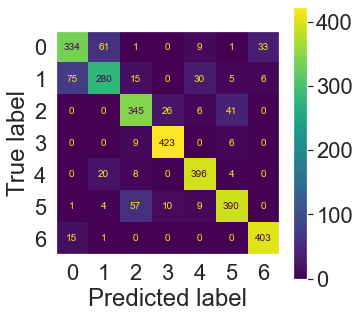


Two Stage Ensemble Confusion Matrix


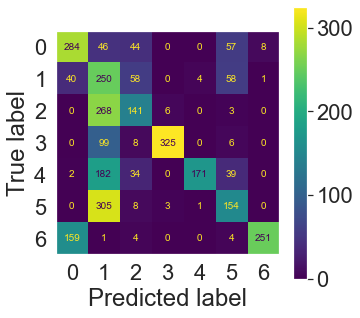

In [108]:
def prediction_probability(subset, base_class, predictions, probabilities):

    pred_prob = np.array([])

    if subset:
    
        for idx, value in enumerate(predictions):
            if value == base_class:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][0])
            else:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][1])
                
    else:
        
        for idx, value in enumerate(predictions):
            if value == 1:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][0])
            elif value == 2:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][1])
            elif value == 3:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][2])
            elif value == 4:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][3])
            elif value == 5:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][4])
            elif value == 6:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][5])
            else:
                pred_prob = np.append(arr=pred_prob, values = probabilities[idx][6])

    return pred_prob

#def ensemble_stage_model():

train_data_norm = normalize_values(train_data, scaler_type = 'StandardScaler')
dev_data_norm = normalize_values(dev_data, scaler_type = 'StandardScaler')


# stage 1
model_1 = RandomForestClassifier(
            criterion = 'entropy',
            max_depth = None,
            max_features = 'auto',
            n_estimators= 150,
            random_state=0
        )
model_1.fit(train_data_norm, train_labels)
model_1_pred = model_1.predict(dev_data_norm)
model_1_prob = model_1.predict_proba(dev_data_norm)
model_1_pred_prob = prediction_probability(subset=False, base_class=0, predictions=model_1_pred, probabilities=model_1_prob)

# stage 2
subset_condition = [1,2]
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset(classes=subset_condition,
                                                                                        train_data=train_data,
                                                                                        dev_data=dev_data)
model_2 = RandomForestClassifier(
            criterion = 'gini',
            max_depth = None,
            max_features = 'auto',
            n_estimators= 50,
            random_state=0
        )
model_2.fit(train_data_subset, train_labels_subset)
model_2_pred = model_2.predict(dev_data)
model_2_prob = model_2.predict_proba(dev_data)
model_2_pred_prob = prediction_probability(subset=True,base_class=1, predictions=model_2_pred, probabilities=model_2_prob)

# stage 3
subset_condition = [3,6]
train_data_subset, train_labels_subset, dev_data_subset, dev_labels_subset = get_subset(classes=subset_condition,
                                                                                        train_data=train_data,
                                                                                        dev_data=dev_data)
model_3 = RandomForestClassifier(
            criterion = 'gini',
            max_depth = None,
            max_features = 'auto',
            n_estimators= 150,
            random_state=0
        )
model_3.fit(train_data_subset, train_labels_subset)
model_3_pred = model_3.predict(dev_data)
model_3_prob = model_3.predict_proba(dev_data)
model_3_pred_prob = prediction_probability(subset=True, base_class=3, predictions=model_3_pred, probabilities=model_3_prob)

# final prediction 
## if stage 1 predicted [1,2] then use stage 2 prediction
## if stage 1 predicted [3,6] then use stage 3 prediction
#model_2_stage_pred = np.array([])
#model_3_stage_pred = np.array([])

final_pred = np.array([])

for idx in range(len(model_1_pred_prob)):
    
    prob_1 = float(model_1_pred_prob[idx])
    prob_2 = float(model_2_pred_prob[idx])
    prob_3 = float(model_3_pred_prob[idx])
    
    if (prob_2 > prob_1) and (prob_2 > prob_3):
        pred = model_2_pred[idx]
    elif prob_3 > prob_1 and prob_3 > prob_2:
        pred = model_3_pred[idx]
    else:
        pred = model_1_pred[idx]
        
    final_pred = np.append(arr=final_pred, values = pred)


model_1_accuracy = (metrics.accuracy_score(dev_labels, model_1_pred)*100)
print(f'One stage accuracy: {model_1_accuracy}')
model_2_stage_accuracy = (metrics.accuracy_score(dev_labels, final_pred)*100)
print(f'One stage accuracy: {model_2_stage_accuracy}')


print('\nOne Stage Ensemble Confusion Matrix')
plot_confusion_matrix(dev_labels, model_1_pred)
print('\nTwo Stage Ensemble Confusion Matrix')
plot_confusion_matrix(dev_labels, final_pred)

#ensemble_stage_model()

One Model accuracy: 85.01984126984127
Ensemble accuracy: 84.78835978835978
\One Model Confusion Matrix


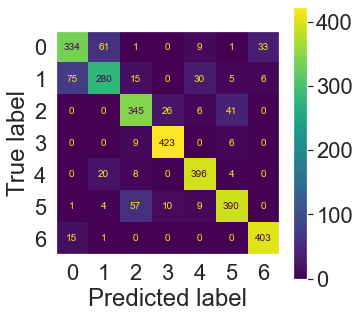


Ensemble Confusion Matrix


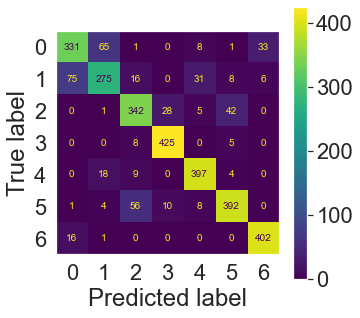

In [123]:
def prediction_probability(predictions, probabilities):

    pred_prob = np.array([])

    for idx, value in enumerate(predictions):
        if value == 1:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][0])
        elif value == 2:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][1])
        elif value == 3:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][2])
        elif value == 4:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][3])
        elif value == 5:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][4])
        elif value == 6:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][5])
        else:
            pred_prob = np.append(arr=pred_prob, values = probabilities[idx][6])

    return pred_prob

#def ensemble_stage_model():

train_data_norm = normalize_values(train_data, scaler_type = 'StandardScaler')
dev_data_norm = normalize_values(dev_data, scaler_type = 'StandardScaler')


model_1 = RandomForestClassifier(
            criterion = 'entropy',
            max_depth = None,
            max_features = 'auto',
            n_estimators= 150,
            random_state=0
        )
model_2 = RandomForestClassifier(
            criterion = 'entropy',
            max_depth = None,
            max_features = 'auto',
            n_estimators= 150,
            random_state=0
        )



model_1.fit(train_data_norm, train_labels)
model_2.fit(train_data, train_labels)


model_1_pred = model_1.predict(dev_data_norm)
model_2_pred = model_2.predict(dev_data)


model_1_prob = model_1.predict_proba(dev_data_norm)
model_2_prob = model_2.predict_proba(dev_data)


model_1_pred_prob = prediction_probability(predictions=model_1_pred, probabilities=model_1_prob)
model_2_pred_prob = prediction_probability(predictions=model_2_pred, probabilities=model_2_prob)


ensemble_pred = np.array([])

for idx in range(len(model_1_pred_prob)):
    
    prob_1 = model_1_pred_prob[idx]
    prob_2 = model_2_pred_prob[idx]
    
    if prob_1 > prob_1:
        pred = model_1_pred[idx]
    else:
        pred = model_2_pred[idx]
        
    ensemble_pred = np.append(arr=ensemble_pred, values = pred)


model_1_accuracy = (metrics.accuracy_score(dev_labels, model_1_pred)*100)
print(f'One Model accuracy: {model_1_accuracy}')
model_2_stage_accuracy = (metrics.accuracy_score(dev_labels, ensemble_pred)*100)
print(f'Ensemble accuracy: {model_2_stage_accuracy}')

print('\One Model Confusion Matrix')
plot_confusion_matrix(dev_labels, model_1_pred)
print('\nEnsemble Confusion Matrix')
plot_confusion_matrix(dev_labels, ensemble_pred)

#ensemble_stage_model()